In [1]:
import torch

# ^^^ pyforest auto-imports - don't write above this line
sys.path.insert(0, "/home/wenhao/Jupyter/wenhao/workspace/torch_ecg/")
sys.path.insert(0, "/home/wenhao/Jupyter/wenhao/workspace/bib_lookup/")

%load_ext autoreload
%autoreload 2

## plots of the databases

In [ ]:
from data_reader import (
    CompositeReader,
    CINC2016Reader,
    CINC2022Reader,
    EPHNOGRAMReader,
    PCGDataBase,
)

In [ ]:
dr = CINC2022Reader("/home/wenhao/Jupyter/wenhao/data/CinC2022/")

In [ ]:
# ?dr.plot_outcome_correlation

In [ ]:
ax = dr.plot_outcome_correlation(col="Murmur")

In [ ]:
# ax.figure.savefig("./images/outcome_murmur_corr.pdf", dpi=1200, bbox_inches="tight", transparent=False);
# ax.figure.savefig("./images/outcome_murmur_corr.svg", dpi=1200, bbox_inches="tight", transparent=False);

In [ ]:
ax = dr.plot_outcome_correlation(col="Age")

In [ ]:
# ax.figure.savefig("./images/outcome_age_corr.pdf", dpi=1200, bbox_inches="tight", transparent=False);
# ax.figure.savefig("./images/outcome_age_corr.svg", dpi=1200, bbox_inches="tight", transparent=False);

In [ ]:
ax = dr.plot_outcome_correlation(col="Sex")

In [ ]:
# ax.figure.savefig("./images/outcome_sex_corr.pdf", dpi=1200, bbox_inches="tight", transparent=False);
# ax.figure.savefig("./images/outcome_sex_corr.svg", dpi=1200, bbox_inches="tight", transparent=False);

In [ ]:
ax = dr.plot_outcome_correlation(col="Pregnancy status")

In [ ]:
# ax.figure.savefig("./images/outcome_pregnancy_status_corr.pdf", dpi=1200, bbox_inches="tight", transparent=False);
# ax.figure.savefig("./images/outcome_pregnancy_status_corr.svg", dpi=1200, bbox_inches="tight", transparent=False);

## Plots of the models

In [2]:
import seaborn as sns
from matplotlib.pyplot import cm
import matplotlib.patches as patches
from tqdm.auto import tqdm

sns.set()

plt.rcParams["xtick.labelsize"] = 28
plt.rcParams["ytick.labelsize"] = 28
plt.rcParams["axes.labelsize"] = 40
plt.rcParams["legend.fontsize"] = 24

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

markers = ["p", "v", "s", "d", "x", "*", "+", "$\heartsuit$"]
marker_size = 12

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
try:
    import bib_lookup
except ModuleNotFoundError:
    sys.path.insert(0, "/home/wenhao/Jupyter/wenhao/workspace/bib_lookup/")
try:
    from torch_ecg.utils.misc import MovingAverage, list_sum
except ModuleNotFoundError:
    sys.path.insert(0, "/home/wenhao/Jupyter/wenhao/workspace/torch_ecg/")
    from torch_ecg.utils.misc import MovingAverage, list_sum

In [4]:
# ma = MovingAverage()
ma_ea = MovingAverage()

ma = lambda x: x

In [5]:
from models import CRNN_CINC2022, Wav2Vec2_CINC2022, HFWav2Vec2_CINC2022

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [9]:
CRNN_CINC2022.__DEBUG__ = False
Wav2Vec2_CINC2022.__DEBUG__ = False
HFWav2Vec2_CINC2022.__DEBUG__ = False

In [6]:
results_dir = Path("./results/").resolve()
results_dir

PosixPath('/home/wenhao/Jupyter/wenhao/workspace/cinc2022/results')

In [7]:
l_csv = list(results_dir.rglob("*.csv"))
l_csv

[PosixPath('/home/wenhao/Jupyter/wenhao/workspace/cinc2022/results/TorchECG_08-09_22-15_task-classification_CRNN_CINC2022_adamw_amsgrad_LR_0.0005_BS_24.csv'),
 PosixPath('/home/wenhao/Jupyter/wenhao/workspace/cinc2022/results/TorchECG_08-11_12-31_task-classification_CRNN_CINC2022_adamw_amsgrad_LR_0.0005_BS_24.csv'),
 PosixPath('/home/wenhao/Jupyter/wenhao/workspace/cinc2022/results/TorchECG_08-07_02-14_task-classification_HFWav2Vec2_CINC2022_adamw_amsgrad_LR_0.0005_BS_24.csv'),
 PosixPath('/home/wenhao/Jupyter/wenhao/workspace/cinc2022/results/TorchECG_08-11_11-35_task-classification_CRNN_CINC2022_adamw_amsgrad_LR_0.0005_BS_24.csv'),
 PosixPath('/home/wenhao/Jupyter/wenhao/workspace/cinc2022/results/TorchECG_08-14_12-30_task-multi_task_HFWav2Vec2_CINC2022_adamw_amsgrad_LR_0.0005_BS_24.csv'),
 PosixPath('/home/wenhao/Jupyter/wenhao/workspace/cinc2022/results/TorchECG_08-13_02-07_task-multi_task_CRNN_CINC2022_adamw_amsgrad_LR_0.0005_BS_24.csv'),
 PosixPath('/home/wenhao/Jupyter/wenhao/wo

In [56]:
loss_map = {"AsymmetricLoss": "Loss-A", "BCEWithLogitsWithClassWeightLoss": "Loss-B"}

In [86]:
cnn_name_map = {
    "multi_scopic": "MB",
    "tresnetF": "TResNetF",
    "tresnetS": "TResNetS",
    "tresnetP": "TResNetP",
    "resnet_nature_comm_bottle_neck_se": "SE-ResNet",
    "resnet_nature_comm": "ResNet-NC",
}

In [111]:
res = {}
with tqdm(l_csv) as t:
    for fp in t:
        if "OutcomeGridSearch" in str(fp):
            continue
        # if "classification" in str(fp):
        #     continue
        lines = (fp.with_suffix(".txt")).read_text().splitlines()
        model_fp = None
        epoch = None
        for l in lines:
            tmp = re.findall("/.*BestModel.*\\.pth\\.tar", l)
            if len(tmp) > 0:
                model_fp = tmp[0]
                epoch = int(re.findall("epoch([\\d]+)_", lines[-1])[0])
        if "CRNN_CINC2022" in model_fp:
            # model, train_cfg = CRNN_CINC2022.from_checkpoint(model_fp)
            train_cfg = torch.load(model_fp)["train_config"]
            task = train_cfg.task
            model_name = "CRNN"
            cnn_name = train_cfg[task].cnn_name
            cnn_name = cnn_name_map.get(cnn_name, cnn_name)
            tag = f"CRNN-{cnn_name}"
            # if cnn_name != "tresnetS":
            #     continue
        elif "HFWav2Vec2_CINC2022" in model_fp:
            # model, train_cfg = HFWav2Vec2_CINC2022.from_checkpoint(model_fp)
            train_cfg = torch.load(model_fp)["train_config"]
            task = train_cfg.task
            model_name = "hf-wav2vec2"
            cnn_name = None
            # encoder_name = train_cfg[task].encoder
            tag = "hf-wav2vec2"
            # continue
        else:
            # model, train_cfg = Wav2Vec2_CINC2022.from_checkpoint(model_fp)
            train_cfg = torch.load(model_fp)["train_config"]
            task = train_cfg.task
            model_name = "ta-wav2vec2"
            cnn_name = train_cfg[task].cnn_name
            cnn_name = cnn_name_map.get(cnn_name, cnn_name)
            # encoder_name = train_cfg[task].encoder
            tag = "ta-wav2vec2"
            # continue
        loss = train_cfg[task].loss
        loss = loss_map[loss["murmur"]]
        tag = tag + "-" + loss
        df_fp = pd.read_csv(fp)
        df_fp.step = df_fp.step.fillna(method="ffill")
        train_loss = df_fp[df_fp.part == "train"][
            ["epoch", "step", "loss", "time", "lr"]
        ].dropna()
        val_metrics = (
            df_fp[df_fp.part == "val"].drop(columns=["loss", "time", "lr"]).dropna()
        )

        res[str(fp)] = dict(
            model_name=model_name,
            cnn_name=cnn_name,
            loss=loss,
            tag=tag,
            task=task,
            train_loss=train_loss,
            val_metrics=val_metrics,
            best_epoch=epoch,
        )

  0%|          | 0/23 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [112]:
len(res)

22

In [113]:
[item["cnn_name"] for item in res.values()]

['TResNetP',
 'TResNetF',
 None,
 'ResNet-NC',
 None,
 'SE-ResNet',
 'SE-ResNet',
 'ResNet-NC',
 'TResNetF',
 'TResNetS',
 'SE-ResNet',
 'SE-ResNet',
 'SE-ResNet',
 'SE-ResNet',
 'TResNetF',
 'TResNetS',
 None,
 'TResNetF',
 'MB',
 'MB',
 'SE-ResNet',
 'TResNetS']

In [128]:
filtered_res = {
    k: v
    for k, v in res.items()
    if v["cnn_name"] == "SE-ResNet"
    and v["model_name"] == "CRNN"
    and v["loss"] == "Loss-A"
}
# filtered_res = {k:v for k,v in res.items() if v["task"] == "classification"}
filtered_res = {
    k: v
    for k, v in res.items()
    if v["cnn_name"] == "TResNetF" and v["model_name"] == "CRNN"
}
filtered_res = {
    k: v
    for k, v in res.items()
    if v["cnn_name"] == "TResNetS"
    and v["model_name"] == "CRNN"
    and v["loss"] == "Loss-A"
}

In [129]:
len(filtered_res)

2

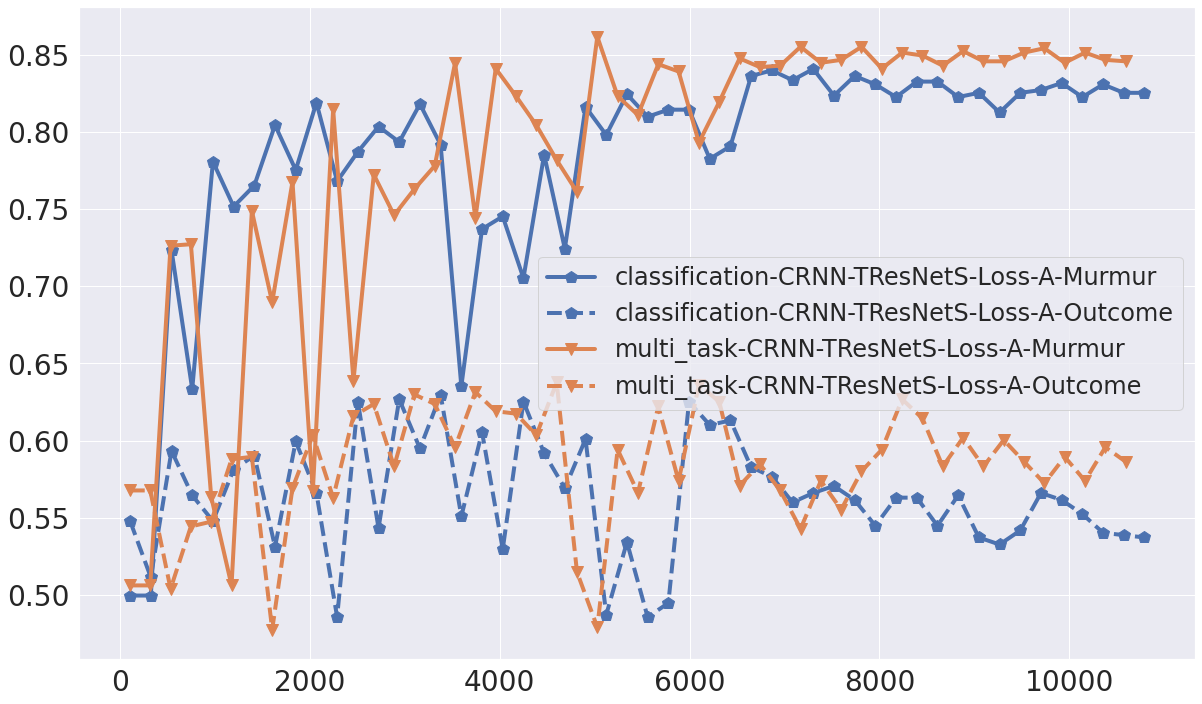

In [131]:
# NOT finished yet
fig, ax = plt.subplots(figsize=(20, 12))

line_width = 4
spacing = 2

# ax2 = ax.twinx()

for idx, (k, v) in enumerate(filtered_res.items()):
    df_val_metrics = v["val_metrics"]
    ax.plot(
        df_val_metrics.step.values[::spacing],
        ma(df_val_metrics.murmur_weighted_accuracy.values)[::spacing],
        marker=markers[idx],
        markersize=marker_size,
        linewidth=line_width,
        color=colors[idx],
        label=f"{v['task']}-{v['tag']}-Murmur",
    )
    ax.plot(
        df_val_metrics.step.values[::spacing],
        ma(df_val_metrics.outcome_accuracy.values)[::spacing],
        marker=markers[idx],
        markersize=marker_size,
        linewidth=line_width,
        color=colors[idx],
        linestyle="dashed",
        label=f"{v['task']}-{v['tag']}-Outcome",
    )
#     ax.axvline(v["best_epoch"] * 108, linewidth=10, color=colors[idx], alpha=0.2)
#     ax.set_ylim(0.4,1.0)
ax.legend()